# Ouput Result Evaluation

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

## Prepare Data

In [20]:
# Constants from the paper
HOLDING_COST_RATE = 0.01  # 1% of unit price
LOST_SALE_COST_RATE = 0.125  # 12.5% of unit price
ORDER_COST_FIXED = 0.5  # fixed $0.5 per order

UNIT_PRICE = { 
    "HOBBIES_1_234": 0.3,
    "FOODS_3_819": 1.89,
    "FOODS_3_090": 1.374,
    "HOUSEHOLD_1_118": 0.97
} 

In [21]:
def get_file_names():
    current_file = os.path.abspath("__file__")
    code_dir = os.path.dirname(current_file)
    data_dir = os.path.join(os.path.dirname(code_dir), "evaluation_output")
    # List all files in the directory
    file_names = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
    print("------------------- File names retrieved successfully -------------------\n")
    return file_names, data_dir

In [4]:
def get_filepath(data_dir, file):
    filepath = os.path.join(data_dir, file)
    print(f"Loaded: {file}")
    return filepath

In [29]:
def extract_efficiency_data(filepath):
    df = pd.read_csv(filepath, skiprows=3, sep=r"\s{2,}", engine='python', header=None, names=["metric", "value"])
    
    with open(filepath, "r") as f:
        lines = f.readlines()
        model = lines[0].strip()
        sku_full = lines[1].strip()
        sku_key = "_".join(sku_full.split("_")[:3])  # extract "FOODS_3_090" from "FOODS_3_090_TX_1_evaluation"

    # Defensive fallback
    if sku_key not in UNIT_PRICE:
        raise ValueError(f"SKU '{sku_key}' not found in UNIT_PRICE dictionary.")

    mean_inventory = float(df[df["metric"] == "mean_inventory"]["value"].values[0])
    lost_sales = float(df[df["metric"] == "lost_sales"]["value"].values[0])
    num_orders = float(df[df["metric"] == "count_orders"]["value"].values[0])
    realized_service_level = float(df[df["metric"] == "service_level"]["value"].values[0])
    RMSSE = float(df[df["metric"] == "RMSSE"]["value"].values[0])
    

    # Access correct unit price
    price = UNIT_PRICE[sku_key]

    holding_cost = mean_inventory * price * HOLDING_COST_RATE
    lost_sales_cost = lost_sales * price * LOST_SALE_COST_RATE
    ordering_cost = num_orders * ORDER_COST_FIXED
    total_cost = holding_cost + lost_sales_cost + ordering_cost

    tsl_match = re.search(r"tsl_(\d+\.\d+)", os.path.basename(filepath)) 
    tsl = float(tsl_match.group(1)) if tsl_match else None

    return {
        "model": model,
        "sku": sku_key,
        "mean_inventory": mean_inventory,
        "lost_sales": lost_sales,
        "num_orders": num_orders,
        "holding_cost": holding_cost,
        "lost_sales_cost": lost_sales_cost,
        "ordering_cost": ordering_cost,
        "total_cost": total_cost,
        "tsl": tsl,
        "realized_service_level": realized_service_level,
        "RMSSE": RMSSE
    }

In [30]:
file_names, data_dir = get_file_names()
all_metrics = []

for file in file_names:
    filepath = get_filepath(data_dir, file)
    metrics = extract_efficiency_data(filepath)
    # print(metrics)
    all_metrics.append(metrics)

df = pd.DataFrame(all_metrics)
df

------------------- File names retrieved successfully -------------------

Loaded: LGBM_HOBBIES_1_234_tsl_0.9.txt
Loaded: ARIMA_HOBBIES_1_234_tsl_0.95.txt
Loaded: LGBM_HOUSEHOLD_1_118_tsl_0.95.txt
Loaded: LGBM_FOODS_3_819_tsl_0.99.txt
Loaded: ARIMA_FOODS_3_819_tsl_0.99.txt
Loaded: LGBM_HOUSEHOLD_1_118_tsl_0.9.txt
Loaded: ARIMA_FOODS_3_819_tsl_0.9.txt
Loaded: ARIMA_FOODS_3_090_tsl_0.99.txt
Loaded: LGBM_FOODS_3_819_tsl_0.9.txt
Loaded: LGBM_FOODS_3_090_tsl_0.99.txt
Loaded: ARIMA_HOUSEHOLD_1_118_tsl_0.95.txt
Loaded: LGBM_HOBBIES_1_234_tsl_0.99.txt
Loaded: LGBM_FOODS_3_090_tsl_0.9.txt
Loaded: ARIMA_HOUSEHOLD_1_118_tsl_0.9.txt
Loaded: ARIMA_FOODS_3_090_tsl_0.9.txt
Loaded: ARIMA_HOBBIES_1_234_tsl_0.9.txt
Loaded: ARIMA_HOUSEHOLD_1_118_tsl_0.99.txt
Loaded: LGBM_HOBBIES_1_234_tsl_0.95.txt
Loaded: ARIMA_FOODS_3_090_tsl_0.95.txt
Loaded: LGBM_FOODS_3_090_tsl_0.95.txt
Loaded: LGBM_FOODS_3_819_tsl_0.95.txt
Loaded: ARIMA_FOODS_3_819_tsl_0.95.txt
Loaded: LGBM_HOUSEHOLD_1_118_tsl_0.99.txt
Loaded: ARIMA_

,model,sku,mean_inventory,lost_sales,num_orders,holding_cost,lost_sales_cost,ordering_cost,total_cost,tsl,realized_service_level,RMSSE
0,LGBM,HOBBIES_1_234,72.664481,224.279014,51.0,0.217993,8.410463,25.5,34.128456,0.90,0.949682,0.030139
1,ARIMA,HOBBIES_1_234,85.244419,10.934831,53.0,0.255733,0.410056,26.5,27.165789,0.95,0.997189,0.026185
2,LGBM,HOUSEHOLD_1_118,117.917279,0.000000,53.0,1.143798,0.000000,26.5,27.643798,0.95,1.000000,0.017717
3,LGBM,FOODS_3_819,37.985767,0.000000,52.0,0.717931,0.000000,26.0,26.717931,0.99,1.000000,0.010411
4,ARIMA,FOODS_3_819,38.488359,0.000000,50.0,0.727430,0.000000,25.0,25.727430,0.99,1.000000,0.010315
5,LGBM,HOUSEHOLD_1_118,106.258403,0.000000,53.0,1.030707,0.000000,26.5,27.530707,0.90,1.000000,0.017717
6,ARIMA,FOODS_3_819,24.644547,0.000000,50.0,0.465782,0.000000,25.0,25.465782,0.90,1.000000,0.010315
7,ARIMA,FOODS_3_090,1847.135565,1327.472678,48.0,25.379643,227.993432,24.0,277.373075,0.99,0.981141,0.025132
8,LGBM,FOODS_3_819,24.115409,0.000000,52.0,0.455781,0.000000,26.0,26.455781,0.90,1.000000,0.010411
9,LGBM,FOODS_3_090,1733.678762,2673.764710,46.0,23.820746,459.219089,23.0,506.039835,0.99,0.951924,0.029201


## Plots

### Efficiency Curve

##### ABS

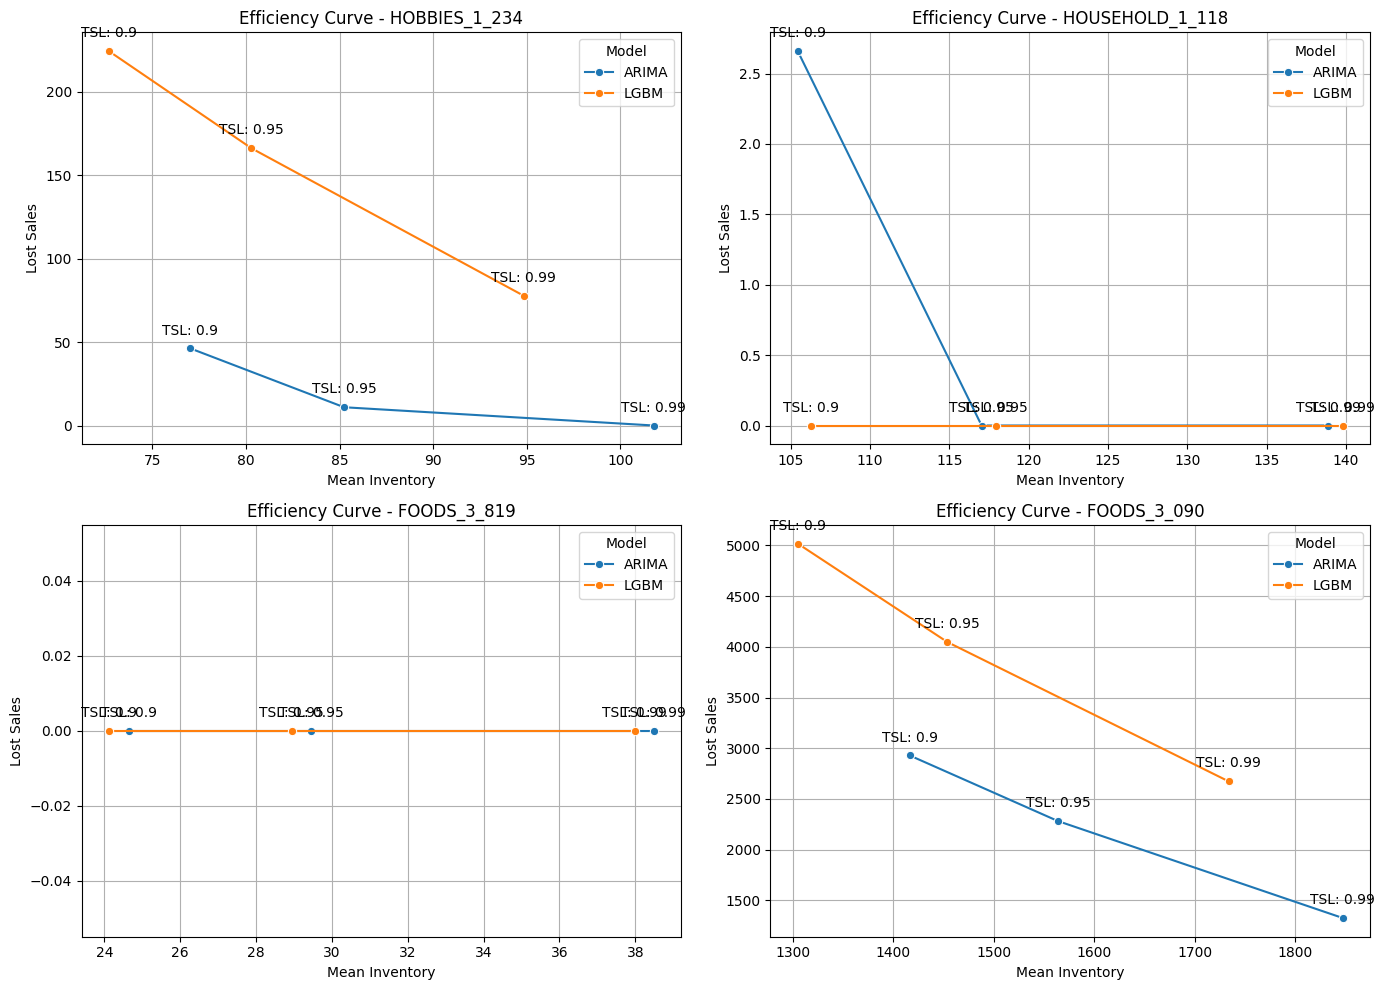

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set consistent palette
palette = {"ARIMA": "#1f77b4", "LGBM": "#ff7f0e"}  # Blue for ARIMA, Orange for LGBM
order = ["ARIMA", "LGBM"]  # Enforced plotting order

# List of unique SKUs
unique_skus = df["sku"].unique()
num_skus = len(unique_skus)

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # 2 rows, 2 columns
axes = axes.flatten()

for i, sku in enumerate(unique_skus):
    ax = axes[i]
    subset = df[df["sku"] == sku]
    
    # Plot with fixed hue order and color palette
    sns.lineplot(data=subset, x="mean_inventory", y="lost_sales",
                 hue="model", hue_order=order, palette=palette,
                 marker="o", ax=ax)

    ax.set_title(f"Efficiency Curve - {sku}")
    ax.set_xlabel("Mean Inventory")
    ax.set_ylabel("Lost Sales")
    ax.grid(True)

    # Force legend order
    handles, labels = ax.get_legend_handles_labels()
    legend_order = [labels.index(m) for m in order if m in labels]
    ax.legend([handles[j] for j in legend_order],
              [labels[j] for j in legend_order], title="Model")

    # Add TSL annotations
    for _, row in subset.iterrows():
        ax.annotate(f"TSL: {row['tsl']}", (row["mean_inventory"], row["lost_sales"]),
                    textcoords="offset points", xytext=(0, 10), ha='center')

# Adjust layout
plt.tight_layout()
plt.show()

### RSL v. TSL

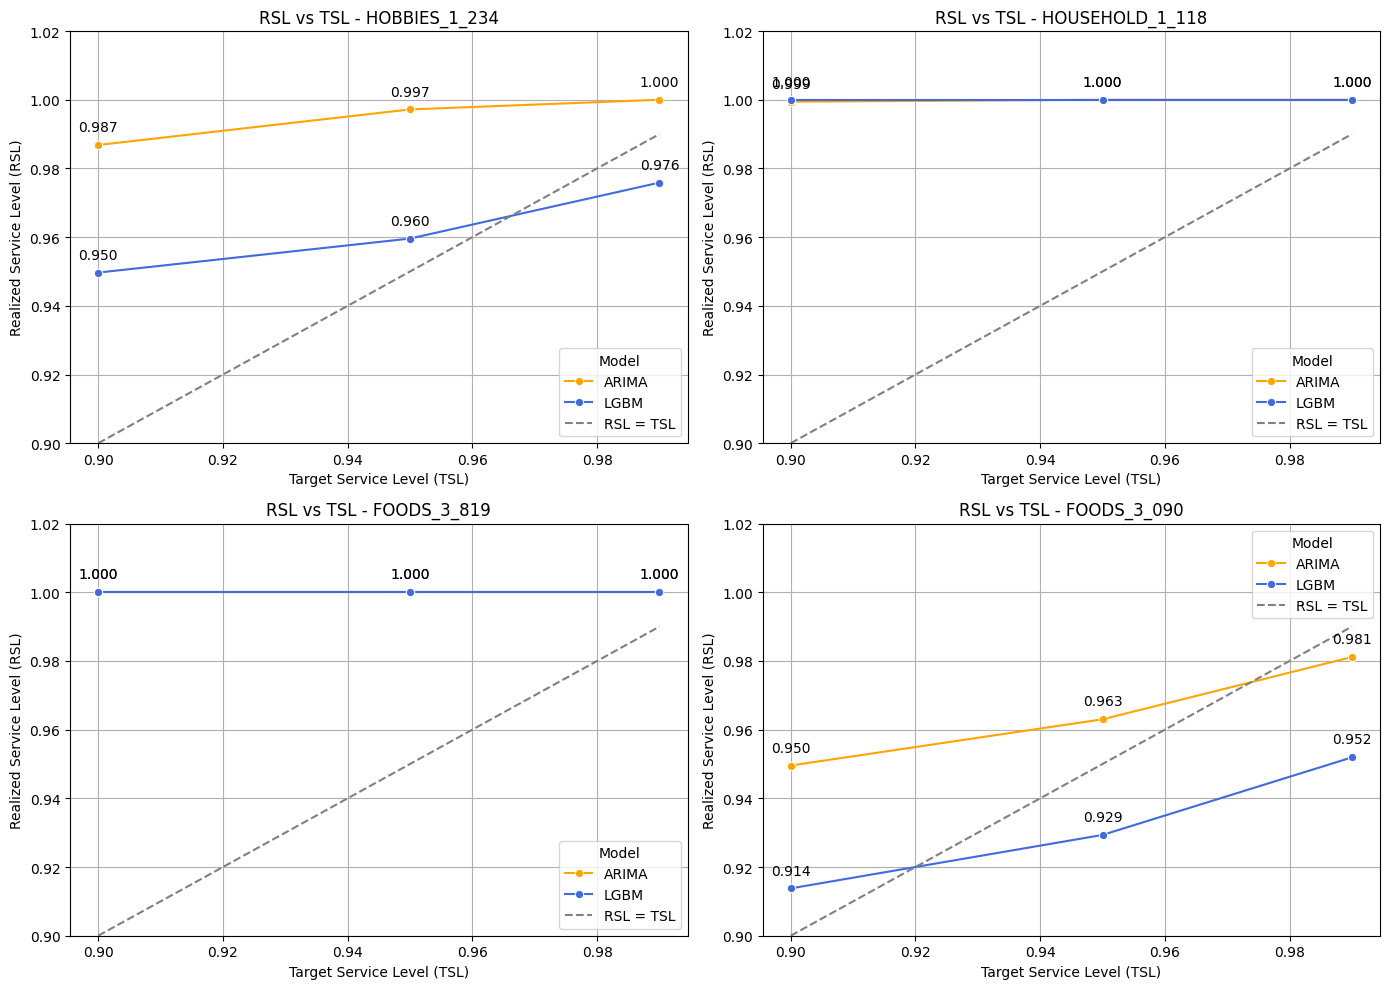

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unique SKUs
unique_skus = df["sku"].unique()

# Define consistent model order and colors
model_order = ["ARIMA", "LGBM"]
palette = {"ARIMA": "orange", "LGBM": "royalblue"}

# Create 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, sku in enumerate(unique_skus):
    ax = axes[i]
    subset = df[df["sku"] == sku].sort_values(by="tsl")

    # Plot forecast lines
    sns.lineplot(data=subset, x="tsl", y="realized_service_level",
                 hue="model", hue_order=model_order,
                 palette=palette, marker="o", ax=ax)

    # Add diagonal reference line: RSL = TSL
    ax.plot(subset["tsl"], subset["tsl"], linestyle="--", color="gray", label="RSL = TSL")

    # Title & labels
    ax.set_title(f"RSL vs TSL - {sku}")
    ax.set_xlabel("Target Service Level (TSL)")
    ax.set_ylabel("Realized Service Level (RSL)")
    ax.set_ylim(0.9, 1.02)
    ax.grid(True)

    # Add annotations for RSL values
    for _, row in subset.iterrows():
        ax.annotate(f"{row['realized_service_level']:.3f}",
                    (row["tsl"], row["realized_service_level"]),
                    textcoords="offset points", xytext=(0, 10), ha='center')

    # Handle legend manually to avoid duplicate "RSL = TSL"
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys(), title="Model")

plt.tight_layout()
plt.show()

### Financial Cost Curve: Total Cost vs TSL
    

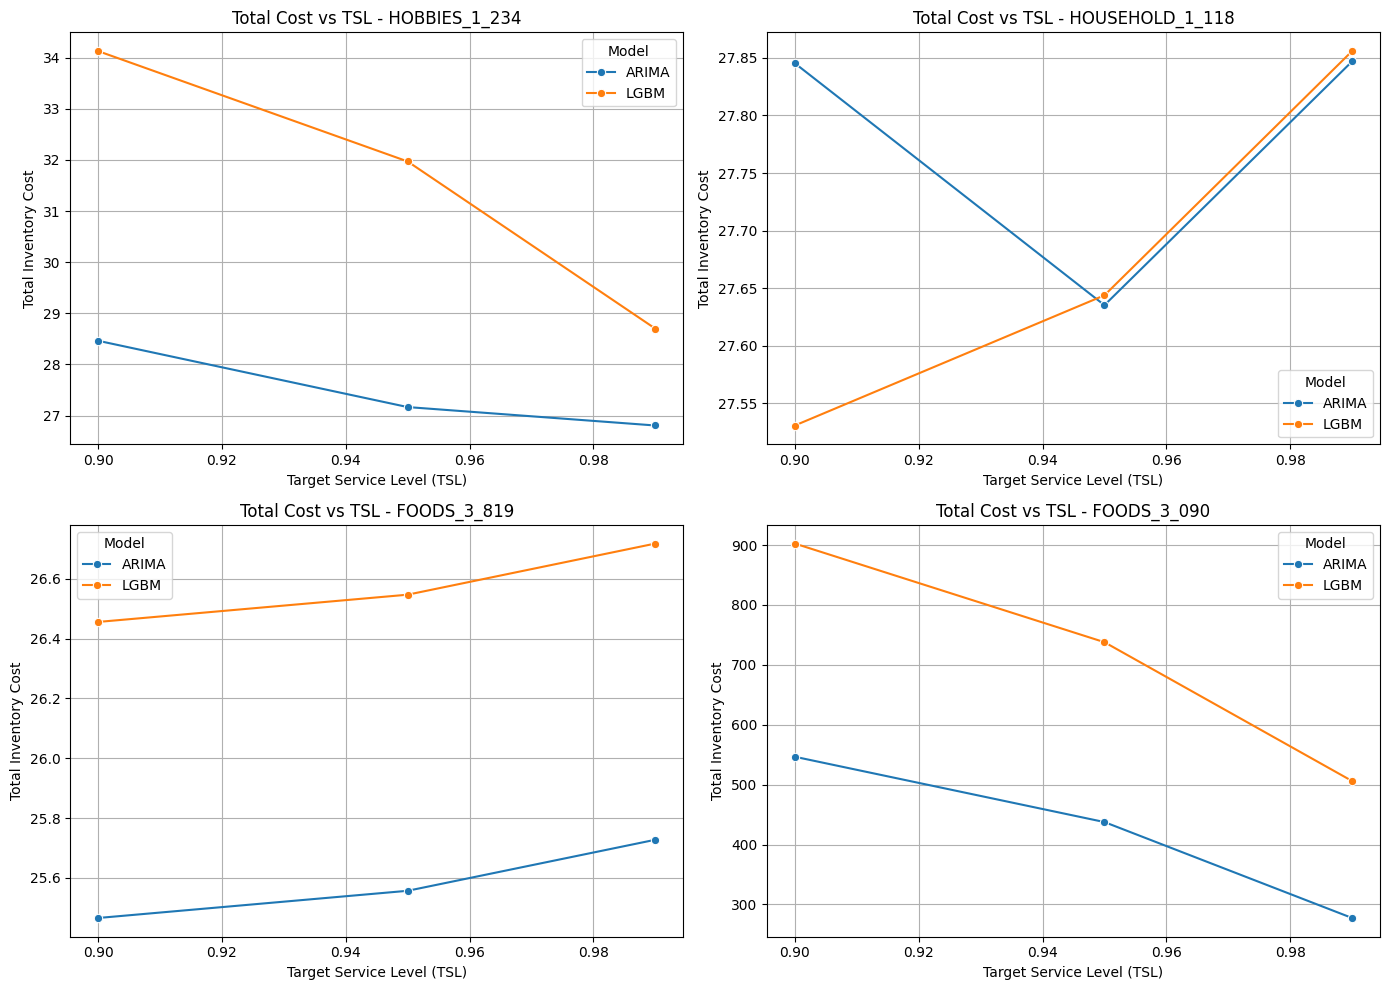

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Set consistent palette and model order
palette = {"ARIMA": "#1f77b4", "LGBM": "#ff7f0e"}  # ARIMA: blue, LGBM: orange
model_order = ["ARIMA", "LGBM"]

# Unique SKUs
unique_skus = df["sku"].unique()
n_skus = len(unique_skus)
n_cols = 2
n_rows = math.ceil(n_skus / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 10))
axes = axes.flatten()

for idx, sku in enumerate(unique_skus):
    ax = axes[idx]
    subset = df[df["sku"] == sku].sort_values("tsl")

    sns.lineplot(data=subset, x="tsl", y="total_cost",
                 hue="model", hue_order=model_order, palette=palette,
                 marker="o", ax=ax)

    ax.set_title(f"Total Cost vs TSL - {sku}")
    ax.set_xlabel("Target Service Level (TSL)")
    ax.set_ylabel("Total Inventory Cost")
    ax.grid(True)

    # Reorder legend to enforce consistency
    handles, labels = ax.get_legend_handles_labels()
    legend_order = [labels.index(m) for m in model_order if m in labels]
    ax.legend([handles[i] for i in legend_order],
              [labels[i] for i in legend_order], title="Model")

# Hide unused axes if fewer than n_rows * n_cols
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Four types of costs vs. nrmse


In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


cost_accuracy_df = df[df["tsl"] == 0.95][["sku", "model", "total_cost", "holding_cost", "lost_sales_cost", "ordering_cost", "RMSSE"]]
cost_accuracy_df

,sku,model,total_cost,holding_cost,lost_sales_cost,ordering_cost,RMSSE
1,HOBBIES_1_234,ARIMA,27.165789,0.255733,0.410056,26.5,0.026185
2,HOUSEHOLD_1_118,LGBM,27.643798,1.143798,0.000000,26.5,0.017717
10,HOUSEHOLD_1_118,ARIMA,27.635225,1.135225,0.000000,26.5,0.013364
17,HOBBIES_1_234,LGBM,31.969453,0.240857,6.228596,25.5,0.030139
18,FOODS_3_090,ARIMA,437.557693,21.487755,392.069937,24.0,0.025132
19,FOODS_3_090,LGBM,737.888869,19.979027,694.909842,23.0,0.029201
20,FOODS_3_819,LGBM,26.546937,0.546937,0.000000,26.0,0.010411
21,FOODS_3_819,ARIMA,25.556764,0.556764,0.000000,25.0,0.010315


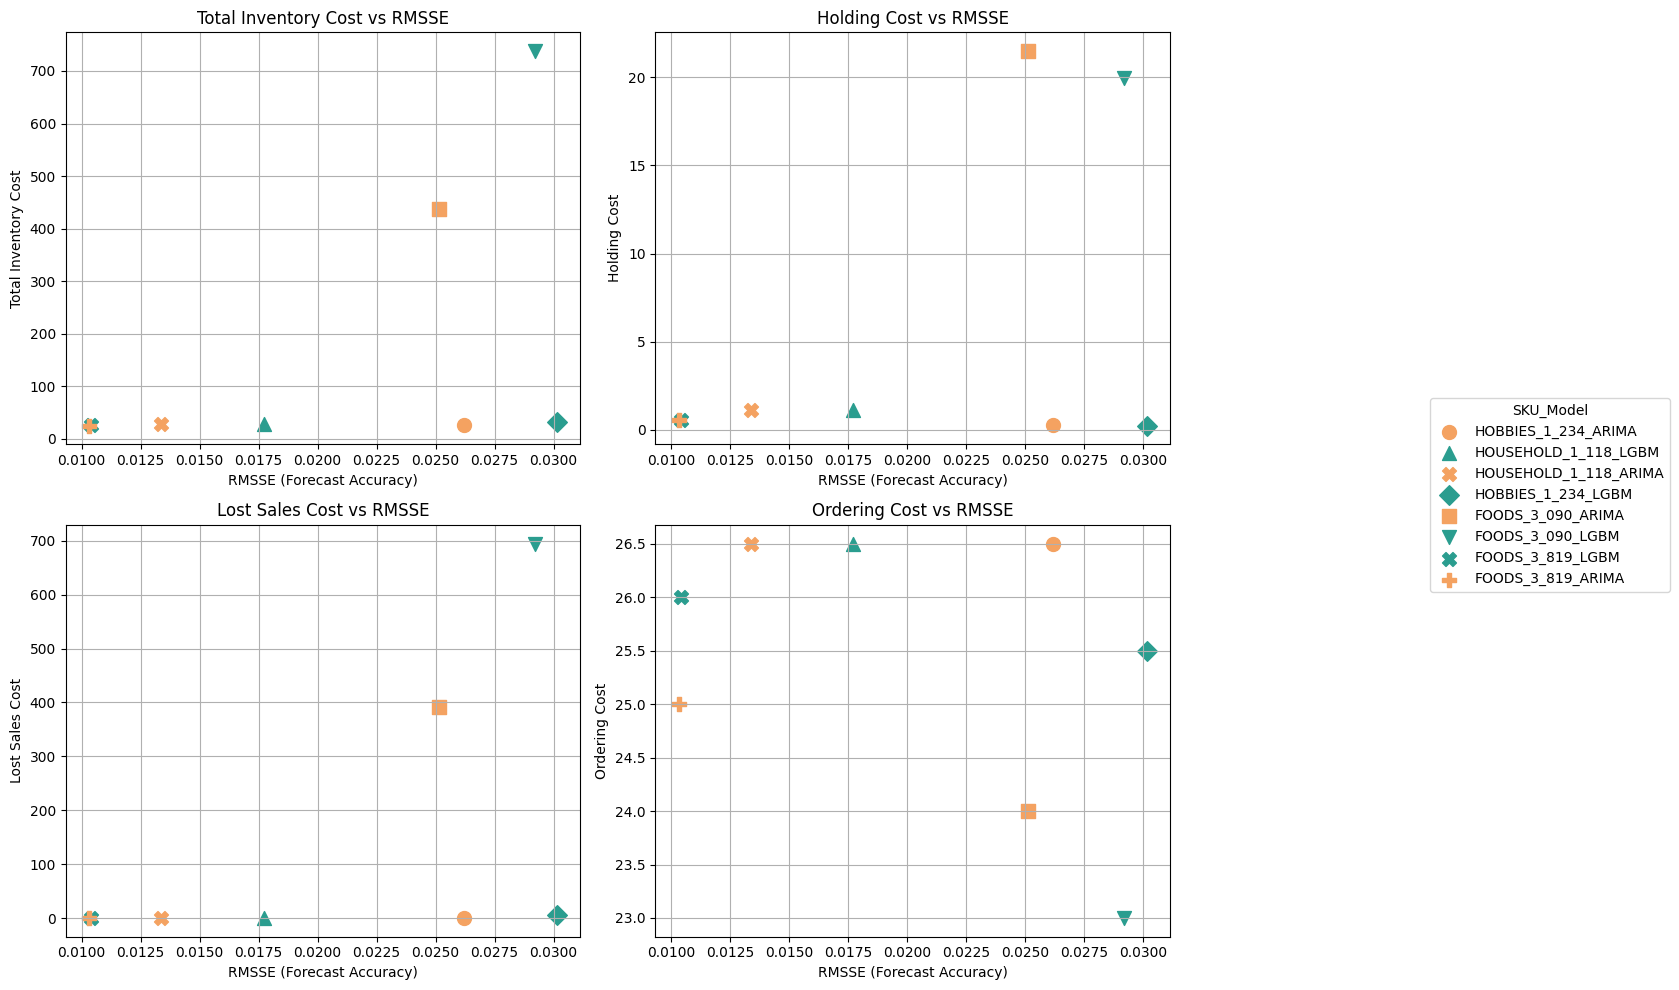

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a combined label column
cost_accuracy_df["label"] = cost_accuracy_df["sku"] + "_" + cost_accuracy_df["model"]

# Define the figure and axes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Define metrics and their titles
metrics = [
    ("total_cost", "Total Inventory Cost"),
    ("holding_cost", "Holding Cost"),
    ("lost_sales_cost", "Lost Sales Cost"),
    ("ordering_cost", "Ordering Cost")
]

# Color palette by model
palette = {
    "ARIMA": "#F4A261",
    "LGBM": "#2A9D8F"
}

# Marker styles by SKU_Model label
markers = {
    "HOBBIES_1_234_ARIMA": "o",
    "HOUSEHOLD_1_118_ARIMA": "X",
    "FOODS_3_090_ARIMA": "s",
    "FOODS_3_819_ARIMA": "P",
    "HOBBIES_1_234_LGBM": "D",
    "HOUSEHOLD_1_118_LGBM": "^",
    "FOODS_3_090_LGBM": "v",
    "FOODS_3_819_LGBM": "X"
}

# Plot each metric
for i, (metric, ylabel) in enumerate(metrics):
    ax = axes[i]
    for label in cost_accuracy_df["label"].unique():
        sub = cost_accuracy_df[cost_accuracy_df["label"] == label]
        model = sub["model"].values[0]
        ax.scatter(
            sub["RMSSE"],
            sub[metric],
            label=label,
            color=palette[model],
            marker=markers[label],
            s=100
        )
    ax.set_title(f"{ylabel} vs RMSSE")
    ax.set_xlabel("RMSSE (Forecast Accuracy)")
    ax.set_ylabel(ylabel)
    ax.grid(True)

# Create one shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="SKU_Model",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5)
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # reserve space for the side legend
plt.show()